In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    # 'text.usetex': True,
    # 'text.latex.preamble': r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

In [2]:
df = pd.read_csv(
    "~/ceph/lola/results/euler_all/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "auto_encoded",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "gamma",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

df = df[~df["auto_encoded"]]
df = df[df["time"] > 0]
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3, 4],
        "std_global": [0.55, 0.25, 0.30, 0.50, 0.50],
    })
)


def horizon(t):
    if t < 20:
        return "1:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:100"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["coverage"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df.loc[df["method"] == "surrogate", "coverage"] = 0.0

To aggregate the metrics of different fields, we use a weighted average where the weights are the fields' instantaneous std, relative to the fields' global std.

In [3]:
weight = df["std_instant"] / df["std_global"]


def weighted_mean(x):
    w = weight[x.index]
    return np.mean(x * w) / np.mean(w)

### Plots

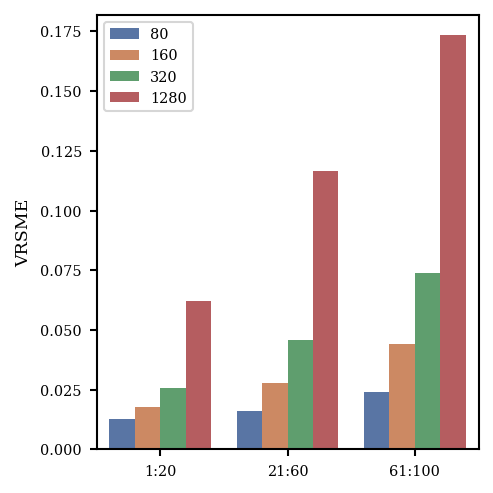

In [4]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(3.2, 3.2))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=weighted_mean,
    errorbar=None,
    palette=sb.color_palette("deep", 4),
)

ax.get_legend().set_title(None)

ax.set_xlabel(None)
ax.set_ylabel("VRSME")

fig.tight_layout(pad=0.33)

plt.savefig("ae_euler.pdf", dpi=300, transparent=True)

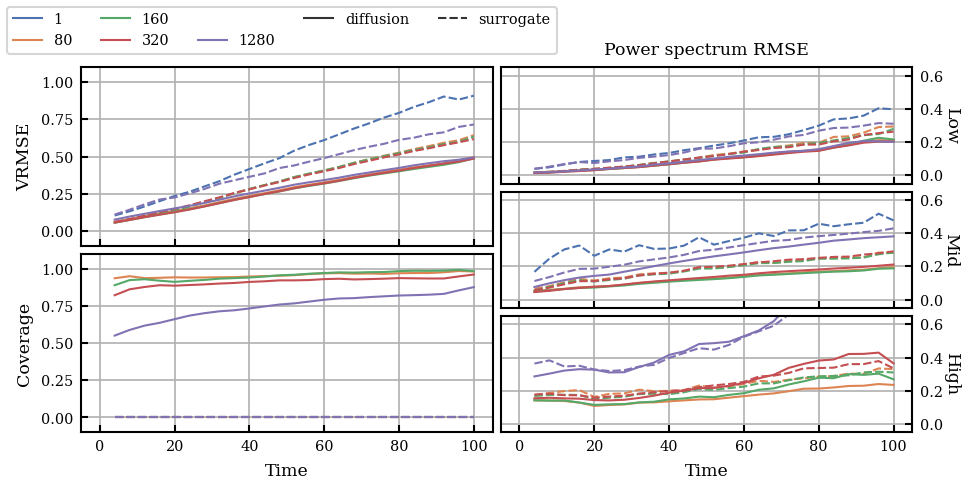

In [5]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "Coverage"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Time")
    ax.set_xlim(-5, 105)

    ax.set_ylabel(metric)
    ax.set_ylim(-0.1, 1.1)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=weighted_mean,
        errorbar=None,
        palette=sb.color_palette("deep", 5),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Time")
    ax.set_xlim(-5, 105)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

handles.insert(-3, blank)
labels.insert(-3, None)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=5)

plt.savefig("mosaic_euler.pdf", dpi=300, transparent=True)

## Tables

In [6]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                   1:20  21:60 61:100
method      compression                     
autoencoder 80           0.013  0.016  0.024
            160          0.018  0.028  0.044
            320          0.026  0.046  0.074
            1280         0.062  0.117  0.173
diffusion   80           0.089  0.217  0.400
            160          0.082  0.210  0.390
            320          0.082  0.210  0.394
            1280         0.104  0.234  0.413
surrogate   1            0.148  0.387  0.766
            80           0.087  0.255  0.510
            160          0.087  0.256  0.506
            320          0.091  0.257  0.499
            1280         0.158  0.341  0.592

In [7]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon             1:20  21:60 61:100
method    context                     
diffusion 1        0.097  0.222  0.411
          2        0.085  0.216  0.396
          3        0.085  0.216  0.388
surrogate 1        0.116  0.287  0.546
          2        0.100  0.270  0.517
          3        0.100  0.275  0.515

In [8]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(weighted_mean).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                       1:20  21:60 61:100       1:20  21:60 61:100   
method      compression                                                     
autoencoder 80               0.002  0.001  0.002      0.008  0.008  0.014   
            160              0.002  0.002  0.002      0.013  0.022  0.042   
            320              0.003  0.003  0.005      0.022  0.049  0.095   
            1280             0.010  0.017  0.027      0.075  0.174  0.304   
diffusion   80               0.024  0.065  0.157      0.063  0.105  0.165   
            160              0.021  0.062  0.155      0.060  0.101  0.161   
            320              0.019  0.062  0.150      0.058  0.109  0.178   
            1280             0.023  0.068  0.160      0.105  0.203  0.333   
surrogate   1                0.058  0.131  0.289      0.256  0.315  0.429   
            80               0.025  0.077  0.203      0.093  0.158  0.241   
            160              0.024  0.077  0.194      0.086  0.152  0.237   
            320              0.024  0.077  0.190      0.082  0.157  0.247   
            1280             0.059  0.119  0.251      0.147  0.245  0.373   

                        rmse_p_high                
horizon                        1:20  21:60 61:100  
method      compression                            
autoencoder 80                0.090  0.078  0.130  
            160               0.105  0.111  0.204  
            320               0.134  0.157  0.321  
            1280              0.288  0.386  0.748  
diffusion   80                0.138  0.132  0.206  
            160               0.139  0.140  0.252  
            320               0.155  0.178  0.351  
            1280              0.309  0.390  0.722  
surrogate   1                 0.788  1.002  2.328  
            80                0.190  0.199  0.279  
            160               0.174  0.181  0.273  
            320               0.177  0.194  0.321  
            1280              0.361  0.382  0.660